# Normalization

Normalization forces all inputs to play by the same rules. We usually want them to have:

- **Mean (average) = 0** (Centered around zero).
- **Standard Deviation (spread) = 1** (Most values between -1 and 1).

## The Math (The Z-Score Formula)
To normalize a value $x$: 

$$
x_{\text{norm}} = \frac{x - \text{mean}}{\text{standard\_deviation}}
$$

- **Subtract the mean:** Moves the center of the data to 0.
- **Divide by std dev:** Squishes (or stretches) the data so the spread is 1.

Now, "Number of Rooms" and "Square Footage" both look like numbers between -1 and 1. The network treats them equally.

# The Pivot to Layer Norm

This is why Layer Normalization was invented.

- **Batch Norm:** "Normalize me relative to the other images in this batch." (Vertical normalization).
- **Layer Norm:** "Normalize me relative to the other neurons in my own vector." (Horizontal normalization).

Layer Norm doesn't care about the other sentences. It looks at the single word embedding vector (say, 512 numbers) and says: "Make the average of these 512 numbers zero."

## The Experiment: "The Death of the Signal"

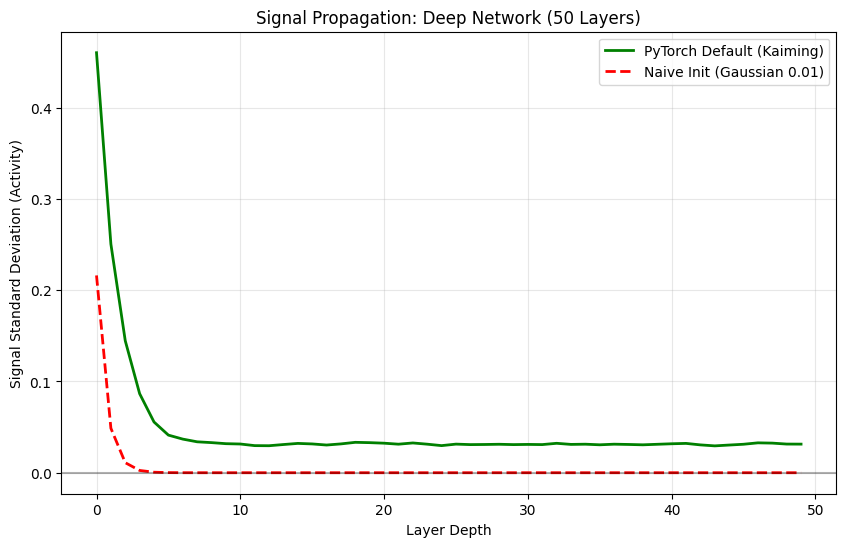

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def visualize_signal_propagation(init_method="default"):
    # 1. Setup
    depth = 50
    dim = 512
    num_samples = 1000
    
    # Input: Healthy Standard Normal Data
    x = torch.randn(num_samples, dim)
    
    # 2. The Network
    layers = []
    for _ in range(depth):
        layer = nn.Linear(dim, dim)
        
        # --- THE SABOTAGE STEP ---
        if init_method == "naive":
            # This is how we used to initialize weights before ~2015
            # Small random numbers. It looks innocent, but it kills deep networks.
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            nn.init.zeros_(layer.bias)
            
        layers.append(layer)
        layers.append(nn.Tanh())
    
    model = nn.Sequential(*layers)
    
    # 3. Forward Pass & Logging
    stds = []
    layer_indices = []
    
    current_x = x
    with torch.no_grad():
        for i, layer in enumerate(model):
            current_x = layer(current_x)
            
            # Only log after the activation function (every 2nd item)
            if isinstance(layer, nn.Tanh):
                # Calculate Std of the signal at this depth
                std = current_x.std().item()
                stds.append(std)
                layer_indices.append(i // 2) # Layer number (0 to 50)

    return layer_indices, stds

# 4. Run Experiment & Plot
plt.figure(figsize=(10, 6))

# Run 1: Default PyTorch Init (Kaiming/Smart)
indices_smart, stds_smart = visualize_signal_propagation(init_method="default")
plt.plot(indices_smart, stds_smart, label="PyTorch Default (Kaiming)", color="green", linewidth=2)

# Run 2: Naive Init (The "Pre-Norm" Problem)
indices_naive, stds_naive = visualize_signal_propagation(init_method="naive")
plt.plot(indices_naive, stds_naive, label="Naive Init (Gaussian 0.01)", color="red", linestyle="--", linewidth=2)

plt.title("Signal Propagation: Deep Network (50 Layers)")
plt.xlabel("Layer Depth")
plt.ylabel("Signal Standard Deviation (Activity)")
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The deeper layers (Layer 40+) are receiving inputs that are basically all zeros.

If the input is zero, the gradient calculation during backpropagation will also be zero.

Result: The network stops learning. The weights never update. The model is "dead."

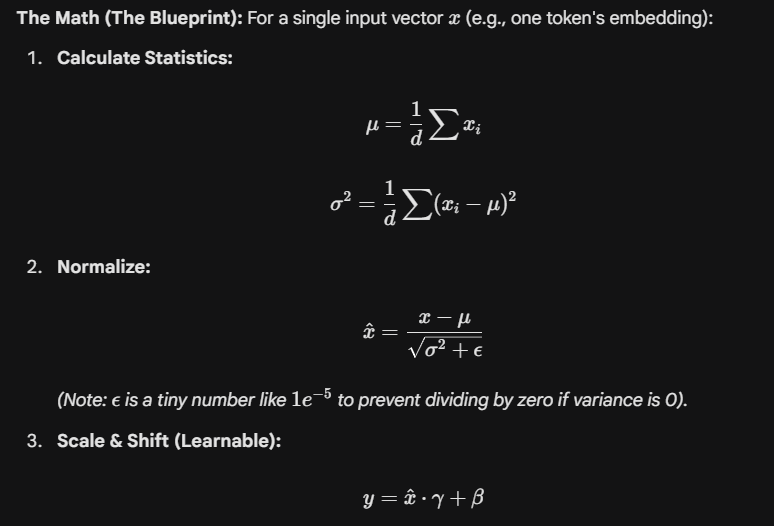


In [3]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
        # 1. The Parameters (The "Knobs")
        # Gamma (Scale): Initialize to 1 (don't scale initially)
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        
        # Beta (Shift): Initialize to 0 (don't shift initially)
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        
        self.eps = eps

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Dim) 
        # We want stats across the LAST dimension (Dim)
        
        # 1. Calculate Mean
        # keepdim=True is crucial! 
        # Turns (32, 10, 512) -> (32, 10, 1) so we can broadcast subtraction
        mean = x.mean(dim=-1, keepdim=True)
        
        # 2. Calculate Variance
        # Var = Mean of (x - mean)^2
        var = ((x - mean) ** 2).mean(dim=-1, keepdim=True)
        
        # 3. Normalize
        # Add eps before sqrt for stability
        std = torch.sqrt(var + self.eps)
        x_norm = (x - mean) / std
        
        # 4. Scale and Shift (The Learnable Part)
        # Gamma and Beta broadcast automatically
        y = x_norm * self.gamma + self.beta
        
        return y

# --- VERIFICATION LAB ---
def test_implementation():
    print("--- Verifying MyLayerNorm vs nn.LayerNorm ---")
    
    # 1. Setup Data
    B, T, C = 2, 5, 4  # Batch, Time, Channels
    x = torch.randn(B, T, C)
    
    # 2. Initialize Both Layers
    my_ln = MyLayerNorm(C)
    torch_ln = nn.LayerNorm(C)
    
    # Force them to have identical weights for comparison
    # (By default they are 1 and 0 anyway, but good practice)
    with torch.no_grad():
        my_ln.gamma.copy_(torch_ln.weight)
        my_ln.beta.copy_(torch_ln.bias)

    # 3. Run Forward Pass
    y_mine = my_ln(x)
    y_torch = torch_ln(x)
    
    # 4. Compare
    # Check if they are close (within 0.000001)
    diff = (y_mine - y_torch).abs().max().item()
    
    print(f"Max Difference: {diff:.8f}")
    if diff < 1e-5:
        print("✅ SUCCESS: Your implementation matches PyTorch exactly.")
    else:
        print("❌ FAILURE: Implementations diverge.")

if __name__ == "__main__":
    test_implementation()

--- Verifying MyLayerNorm vs nn.LayerNorm ---
Max Difference: 0.00000036
✅ SUCCESS: Your implementation matches PyTorch exactly.


## RMSNorm (Root Mean Square Norm)

Think back to LayerNorm. It does two things:Re-centering: Subtracts the mean ($\mu$) to shift the graph to 0.Re-scaling: Divides by variance ($\sigma$) to shrink/expand the graph.The Discovery (2019): Researchers found that Re-centering is expensive and unnecessary.Calculating the Mean requires summing the whole vector. Subtracting it requires another pass.It turns out, the "Re-scaling" part is what actually keeps the gradients stable.RMSNorm Strategy:Don't calculate the mean. Don't subtract it.Just calculate the magnitude (Root Mean Square) and divide by it.Result: Faster calculation, same stability.

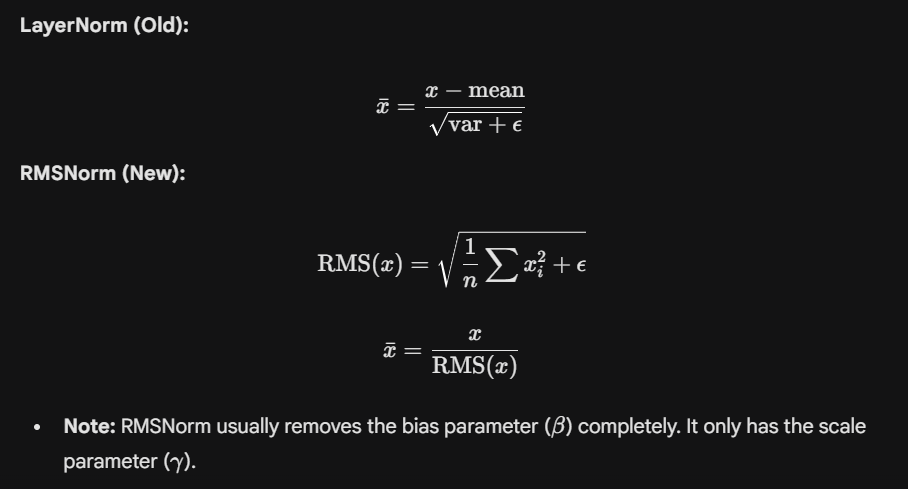

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        
        # The Scale Parameter (Gamma)
        # Note: No Beta (Shift) parameter in standard RMSNorm!
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        # 1. Calculate RMS
        # mean(x^2) -> square root
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # 2. Normalize and Scale
        # Usually we convert to float32 for the norm calc to avoid overflow/underflow
        output = self._norm(x.float()).type_as(x)
        
        return output * self.weight

# --- VERIFICATION LAB ---
def compare_norms():
    x = torch.randn(2, 5, 4) # Batch, Seq, Dim
    
    ln = nn.LayerNorm(4)
    rms = RMSNorm(4)
    
    print(f"Input: {x[0,0].tolist()}")
    print(f"LayerNorm: {ln(x)[0,0].tolist()}")
    print(f"RMSNorm:   {rms(x)[0,0].tolist()}")
    
    # Notice: RMSNorm values are slightly different because they aren't centered at 0
    # But they are still bounded and stable!

if __name__ == "__main__":
    compare_norms()

Input: [0.7632403373718262, -0.13564756512641907, -0.8962355256080627, 0.7258767485618591]
LayerNorm: [0.9468551874160767, -0.36471036076545715, -1.474482774734497, 0.8923380374908447]
RMSNorm:   [1.09847891330719, -0.19522814452648163, -1.2898896932601929, 1.0447040796279907]
